In [1]:
import pandas as pd


In [2]:
df = pd.read_csv(
    "data/NewsAggregatorDataset/newsCorpora.csv",
    header=None,
    sep="\t",
    names=["id", "title", "url", "publisher", "category", "story", "hostname", "timestamp"],
)
cols = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
df = df[df["publisher"].isin(cols)]


In [3]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,id,title,url,publisher,category,story,hostname,timestamp
0,822,"GLOBAL MARKETS-World stocks, copper and oil fa...",http://in.reuters.com/article/2014/03/10/marke...,Reuters,b,dn8H6sYjpAZnsgM2qvfMRDttKqhXM,in.reuters.com,1394490293060
1,243226,Phil Robertson Is A Modern-Day Prophet Akin To...,http://www.huffingtonpost.com/2014/05/23/phil-...,Huffington Post,e,dWycSTQ-r2QSfRMaSLcJbYR8u3xeM,www.huffingtonpost.com,1400876539212
2,352577,"Beyonce Changes Lyrics To 'Resentment,' Intern...",http://www.huffingtonpost.com/2014/07/02/beyon...,Huffington Post,e,dITwFC605fYT0CM7vjCojyB27rL4M,www.huffingtonpost.com,1404403216532
3,73971,Apple-Samsung Jury Is Seated in Patent Trial i...,http://www.businessweek.com/news/2014-03-31/ap...,Businessweek,t,dh64qhIU4xsjuWM2ePux8Jlw-c2JM,www.businessweek.com,1396346573625
4,293409,Pucker up! Daddy's girl Nicole Kidman plays th...,http://www.dailymail.co.uk/tvshowbiz/article-2...,Daily Mail,e,dtbVc8ZNz17etAMR19iaXK0PzVoNM,www.dailymail.co.uk,1402954444732


(b = business, t = science and technology, e = entertainment, m = health)

In [4]:
df.shape


(13340, 8)

## 51. 特徴量抽出

In [5]:
from sklearn.model_selection import train_test_split

train, rest = train_test_split(df, test_size=0.2, random_state=42, stratify=df["category"])
valid, test = train_test_split(rest, test_size=0.5, random_state=42, stratify=rest["category"])


## 52. 学習, 53. 予測

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# [Choosing the right estimator — scikit\-learn 1\.0\.2 documentation](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
# As cheat sheet, Use LinearSVC or Naive Bayes for Text Classification.

text_nb_clf = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf", MultinomialNB())])


In [7]:
text_nb_clf.fit(train["title"], train["category"])


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

## 54. 正解率の計測

In [8]:
import numpy as np

np.mean(text_nb_clf.predict(train["title"]) == train["category"])


0.8794977511244377

In [9]:
np.mean(text_nb_clf.predict(valid["title"]) == valid["category"])


0.841079460269865

## 55. 混同行列の作成

In [10]:
labels = valid["category"].unique()
labels


array(['b', 'e', 't', 'm'], dtype=object)

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(valid["category"], text_nb_clf.predict(valid["title"]), labels=labels)
# 混同行列は y_true に現れた順 https://stackoverflow.com/questions/63649660/how-to-know-scikit-learn-confusion-matrixs-label-order-and-change-it


array([[544,  18,   0,   0],
       [  5, 523,   0,   0],
       [ 67,  44,  42,   0],
       [ 38,  39,   1,  13]])

## 56. 適合率，再現率，F1スコアの計測

In [12]:
from sklearn import metrics

print(metrics.accuracy_score(valid["category"], text_nb_clf.predict(valid["title"])))
# accuracy: 正解率

print(metrics.classification_report(valid["category"], text_nb_clf.predict(valid["title"]), labels=labels))
# precision: 適合率. TP / (TP + FP). FNを許容できる、つまり多少の足切りがOKな場合に使う。
# recall: 再現率. TP / (TP + FN). FPを許容できる、つまり取りこぼしを減らしたいときに使う。
# f1-score: F1スコア. 適合率と再現率の調和平均。つまり、適合率と再現率のどちらか一方が大きいときに、片方犠牲にしてませんか？というのを確かめるために使う。


0.841079460269865
              precision    recall  f1-score   support

           b       0.83      0.97      0.89       562
           e       0.84      0.99      0.91       528
           t       0.98      0.27      0.43       153
           m       1.00      0.14      0.25        91

    accuracy                           0.84      1334
   macro avg       0.91      0.59      0.62      1334
weighted avg       0.86      0.84      0.80      1334



分析結果を見ると、m(health)とt(science and technology)のf1-scoreが低い。原因はrecallの低さだ。  
つまり、health と science and technologyがbusinessやentertainmentに誤ってカテゴライズされている可能性がある（それらのprecision...合格者の成績優秀率...が低いことも裏付けになる。)  
もしかして、検証データのカテゴリの数を揃えたらうまくいくのか？

## 57. 特徴量の重みの確認

In [13]:
clf: MultinomialNB = text_nb_clf["clf"]
# clf.coef_ # deprecated
feature_log_prob_ = clf.feature_log_prob_
feature_log_prob_

# それぞれのfeatureにおける、それぞれのcategoryについての事前確率を求める。元々の値は 0.XXXX... だが、自然対数に変換されている。


array([[ -9.66390573,  -9.84145788,  -9.79903366, ..., -10.17741708,
        -10.17741708, -10.17741708],
       [-10.14486092, -10.14486092, -10.14486092, ...,  -9.78548793,
         -9.81401107,  -9.79927393],
       [ -9.61751889,  -9.61751889,  -9.61751889, ...,  -9.61751889,
         -9.61751889,  -9.61751889],
       [ -9.70939119,  -9.70939119,  -9.70939119, ...,  -9.70939119,
         -9.70939119,  -9.70939119]])

In [14]:
clf.coef_.shape


/Users/hiroga/.ghq/github.com/xhiroga/til/computer-science/nlp/nlp100/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


(4, 12810)

In [15]:
type(feature_log_prob_)


numpy.ndarray

In [16]:
clf.classes_


array(['b', 'e', 'm', 't'], dtype='<U1')

In [17]:
feature_names = text_nb_clf[:-1].get_feature_names_out()
feature_names


array(['00', '07', '08', ..., 'œlousyâ', 'œpiece', 'œwaist'], dtype=object)

In [18]:
features_df = pd.DataFrame(feature_log_prob_, columns=feature_names, index=clf.classes_).head()
features_df


,00,07,08,09,0ff,0ut,10,100,1000,10000,...,zombies,zone,zooey,zoosk,zuckerberg,zynga,œf,œlousyâ,œpiece,œwaist
b,-9.663906,-9.841458,-9.799034,-9.856387,-10.177417,-9.833884,-7.592240,-8.282525,-9.429783,-10.177417,...,-9.807179,-7.456849,-10.177417,-9.810089,-10.177417,-9.601588,-10.177417,-10.177417,-10.177417,-10.177417
e,-10.144861,-10.144861,-10.144861,-10.144861,-9.819477,-10.144861,-8.214506,-8.741159,-10.144861,-10.144861,...,-10.144861,-10.144861,-9.810165,-10.144861,-10.144861,-10.144861,-9.830686,-9.785488,-9.814011,-9.799274
m,-9.617519,-9.617519,-9.617519,-9.617519,-9.617519,-9.617519,-8.927160,-8.707421,-9.107889,-9.617519,...,-9.617519,-9.387898,-9.617519,-9.617519,-9.617519,-9.617519,-9.617519,-9.617519,-9.617519,-9.617519
t,-9.709391,-9.709391,-9.709391,-9.709391,-9.709391,-9.709391,-8.836892,-9.230319,-9.401655,-9.387534,...,-9.709391,-9.479985,-9.709391,-9.709391,-8.934037,-9.709391,-9.709391,-9.709391,-9.709391,-9.709391


<AxesSubplot:>

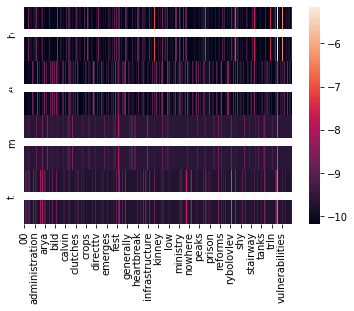

In [19]:
import seaborn as sns

sns.heatmap(features_df, annot=True, fmt=".2f")
# 実行に2分かかる。


## 58. 正則化パラメータの変更 & 59. ハイパーパラメータの探索

In [20]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "vect__ngram_range": [(1, 1), (1, 2)],
    "tfidf__use_idf": (True, False),
    "clf__alpha": (1e-2, 1e-3),
}


In [21]:
gs_clf = GridSearchCV(text_nb_clf, parameters, cv=5, n_jobs=-1)  # n_jobs=-1 means all CPUs


In [22]:
gs_clf = gs_clf.fit(train["title"], train["category"])


In [23]:
gs_clf.best_score_


0.9133239246810314

In [ ]:
gs_clf != None
